# imports

In [6]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
# import tensorflow
import warnings
# import torch
warnings.filterwarnings(action='ignore')
%matplotlib inline

PLAN
1. make days since user account creation until post
2. title length
3. body legnth
4. num tags

In [27]:
df = pd.read_csv('data/train-sample.csv')
df.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


In [36]:
df.shape

(140272, 15)

In [35]:
list(df.OpenStatus.unique())

['open',
 'too localized',
 'not a real question',
 'off topic',
 'not constructive']

In [33]:
df.loc[df.OpenStatus == 'not a real question'].head(1)['BodyMarkdown'].to_list()

['I want to write a program that give a path in my system and goes to that path and search in that path and sub-directory of path and list all of .txt file . \r\nplease help me .\r\nthanks .']

I want to write a program that give a path in my system and goes to that path and search in that path and sub-directory of path and list all of .txt file . \r\nplease help me .\r\nthanks .


# Target

In [4]:
df.OpenStatus.value_counts()

open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: OpenStatus, dtype: int64

# Tags
 - 18308 unique tags

In [5]:
df['numTags'] = df[['Tag1','Tag2','Tag3','Tag4','Tag5']].transpose().notna().sum()
df.numTags.value_counts()

2    37120
3    36276
1    27232
4    23939
5    15701
0        4
Name: numTags, dtype: int64

# AccountAge
Days Since Owner Account Creation Until Post

In [6]:
df[['PostCreationDate','OwnerCreationDate']] = df[['PostCreationDate','OwnerCreationDate']].apply(pd.to_datetime)
df['AccountAge'] = (df['PostCreationDate'] - df['OwnerCreationDate']).dt.days
# drop 60 negative account ages
df = df.loc[df.AccountAge >= 0]
df.AccountAge.describe()

count    140212.000000
mean        215.868171
std         270.062908
min           0.000000
25%           7.000000
50%         103.000000
75%         335.000000
max        1437.000000
Name: AccountAge, dtype: float64

# Reputation

In [7]:
# drop 213 impossible reputation rows < 1
df = df.loc[df.ReputationAtPostCreation > 0]
df.ReputationAtPostCreation.describe()

count    139999.000000
mean        507.606240
std        2498.234813
min           1.000000
25%           1.000000
50%          36.000000
75%         269.000000
max      209631.000000
Name: ReputationAtPostCreation, dtype: float64

# Owner Answer Contibutions
21814 outliers above (20) contributions at the time of post

count    140272.000000
mean          2.225100
std           3.810108
min           0.000000
25%           0.000000
50%           1.000000
75%           2.828427
max          75.973680
Name: OwnerUndeletedAnswerCountAtPostTime, dtype: float64

outlier_upper_bound 7.0710678118654755
num_outliers 11330


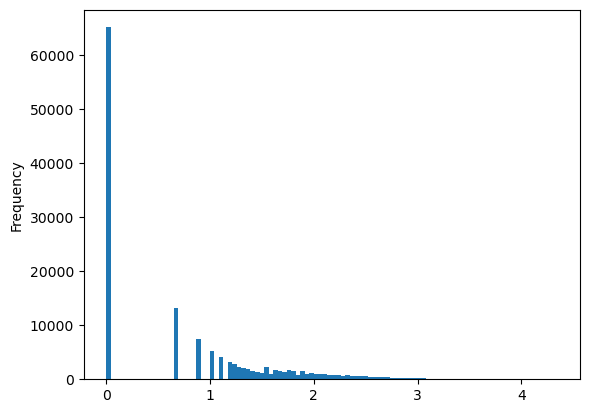

In [7]:
display(df.OwnerUndeletedAnswerCountAtPostTime.describe())
upper_quartile = df.OwnerUndeletedAnswerCountAtPostTime.quantile(.75)
lower_quartile = df.OwnerUndeletedAnswerCountAtPostTime.quantile(.25)
iqr = upper_quartile - lower_quartile
outlier_upper_bound = upper_quartile + 1.5 * (iqr)
print('outlier_upper_bound',outlier_upper_bound)
print('num_outliers', df.loc[df.OwnerUndeletedAnswerCountAtPostTime > outlier_upper_bound].shape[0])
max_ = np.sqrt(df.OwnerUndeletedAnswerCountAtPostTime.max())
df.OwnerUndeletedAnswerCountAtPostTime = (
    df.OwnerUndeletedAnswerCountAtPostTime.map(lambda x: np.log(x+1))
)
df.OwnerUndeletedAnswerCountAtPostTime.plot(kind='hist', bins=100);

# Text Preprocessing
Join tags, title and body as one text input

In [12]:
mask = df[['Tag1','Tag2','Tag3','Tag4','Tag5','Title','BodyMarkdown']].isna()
tag_values = ma.masked_array(df[['Tag1','Tag2','Tag3','Tag4','Tag5','Title','BodyMarkdown']], mask=mask)
df['text'] = [". ".join(row_tags.compressed()) for row_tags in tag_values]


In [80]:
# make title and body word count features
df['title_wc'] = df.Title.map(lambda x: len(x.split()))
df['body_wc'] = df.BodyMarkdown.map(lambda x: len(x.split()))

# tokenizing

In [22]:
import html
import re

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text.strip()

In [24]:
clean(df.text.iloc[1])

'dom. xsd. jaxp. how to insert schemalocation in a xml document via dom. i create a xml document with jaxp and search a way to insert the schemalocation. at the moment my application produces: ... but i need: ... my code: streamresult result = new streamresult(writer); document doc = getdocument(); transformer trans = transfac.newtransformer(); trans.setoutputproperty(outputkeys.indent, "yes"); trans.setoutputproperty(outputkeys.method, "xml"); trans.setoutputproperty(outputkeys.version, "1.0"); trans.setoutputproperty(outputkeys.encoding, "utf-8"); domsource source = new domsource(depl.getaselement(doc)); trans.transform(source, result); thanks for your time, kasten'

In [23]:
import nltk
import nltk.tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

tokens = tokenizer.tokenize(text)
# stop_words = set(stopwords.words('english'))
# filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
tokens


['dom',
 'xsd',
 'jaxp',
 'how',
 'to',
 'insert',
 'schemalocation',
 'in',
 'a',
 'xml',
 'document',
 'via',
 'dom',
 'i',
 'create',
 'a',
 'xml',
 'document',
 'with',
 'jaxp',
 'and',
 'search',
 'a',
 'way',
 'to',
 'insert',
 'the',
 'schemalocation',
 'at',
 'the',
 'moment',
 'my',
 'application',
 'produces',
 'but',
 'i',
 'need',
 'my',
 'code',
 'streamresult',
 'result',
 'new',
 'streamresult',
 'writer',
 'document',
 'doc',
 'getdocument',
 'transformer',
 'trans',
 'transfac',
 'newtransformer',
 'trans',
 'setoutputproperty',
 'outputkeys',
 'indent',
 'yes',
 'trans',
 'setoutputproperty',
 'outputkeys',
 'method',
 'xml',
 'trans',
 'setoutputproperty',
 'outputkeys',
 'version',
 '1',
 '0',
 'trans',
 'setoutputproperty',
 'outputkeys',
 'encoding',
 'utf',
 '8',
 'domsource',
 'source',
 'new',
 'domsource',
 'depl',
 'getaselement',
 'doc',
 'trans',
 'transform',
 'source',
 'result',
 'thanks',
 'for',
 'your',
 'time',
 'kasten']

# Title

In [37]:
df.Title.to_list()

['For Mongodb is it better to reference an object or use a natural String key?',
 'How to insert schemalocation in a xml document via DOM',
 'Too many lookup tables ',
 'What is this PHP code in VB.net',
 'Spring-Data mongodb querying multiple classes stored in the same collection',
 'stop ajax function in midway when other element is clicked',
 'Regex to detect Javascript In a string',
 'List of all .txt file',
 'I want to design an invitation card for my wedding in silverlight ',
 'VB Script To Delete Header and Footer plus Append Text while exporting to new text file',
 'In GEF bendpoints, how can i retrieve point from first and second dimension?',
 'Is It Possible to Create CSV File with Multiple Tabs in Command Prompt?',
 'How to write shellextension contextmenuitem in codegear c++ 2010',
 "How to add special character's like & > in xml file using java-script",
 'How VPN spliting Done in .Net Using C#',
 'Cell colors in a GWT CellTable',
 'Sequential CSS3 animation',
 'can a stron

# Body

In [10]:
df.BodyMarkdown.head(5).to_list()

['I am building a corpus of indexed sentences in different languages. I have a collection of Languages which have both an ObjectId and the ISO code as a key. Is it better to use a reference to the Language collection or store a key like "en" or "fr"?\r\n\r\nI suppose it\'s a compromise between:\r\n\r\n - ease of referencing the Language\r\n - object in that collection\r\n - speed in doing queries where the sentence has a certain language\r\n - the size of the data on disk\r\n\r\nAny best practices that I should know of?',
 'i create a xml document with JAXP and search a way to insert the schemalocation.\r\nAt the moment my application produces:\r\n\r\n    <?xml version="1.0" encoding="UTF-8"?>\r\n    <root>\r\n    ...\r\n    </root>\r\n\r\nBut i need:\r\n\r\n    <?xml version="1.0" encoding="UTF-8"?>\r\n    <root xmlns="namespaceURL" \r\n    xmlns:xs="http://www.w3.org/2001/XMLSchema-instance"\r\n    xs:schemaLocation="namespaceURL pathToMySchema.xsd">\r\n    ...\r\n    </root>\r\n\r\n

 What are the adverse effects of having too many lookup tables in the database?\r\n\r\n I have to incorportate too many Enumerations, based on the applications. \r\n\r\nWhat would experts advice?


I am building a corpus of indexed sentences in different languages. I have a collection of Languages which have both an ObjectId and the ISO code as a key. Is it better to use a reference to the Language collection or store a key like "en" or "fr"?

I suppose it's a compromise between:

 - ease of referencing the Language
 - object in that collection
 - speed in doing queries where the sentence has a certain language
 - the size of the data on disk

Any best practices that I should know of?

i create a xml document with JAXP and search a way to insert the schemalocation.
At the moment my application produces:

    <?xml version="1.0" encoding="UTF-8"?>
    <root>
    ...
    </root>

But i need:

    <?xml version="1.0" encoding="UTF-8"?>
    <root xmlns="namespaceURL" 
    xmlns:xs="http://www.w3.org/2001/XMLSchema-instance"
    xs:schemaLocation="namespaceURL pathToMySchema.xsd">
    ...
    </root>

My code:

    StreamResult result = new StreamResult(writer);
    Document doc = getDocument();

    Transformer trans = transfac.newTransformer();
    trans.setOutputProperty(OutputKeys.INDENT, "yes");
    trans.setOutputProperty(OutputKeys.METHOD, "xml");
    trans.setOutputProperty(OutputKeys.VERSION, "1.0");
    trans.setOutputProperty(OutputKeys.ENCODING, "UTF-8");

    DOMSource source = new DOMSource(depl.getAsElement(doc));
    trans.transform(source, result);


Thanks for your time,  
Kasten

I am looking for the vb.net equivalent of this function: I have no experience of PHP but came across this code which apparently gives you a random image url from google images 

        function GetRandomImageURL($topic='', $min=0, $max=100)
    {
      // get random image from Google
      if ($topic=='') $topic='image';
      $ofs=mt_rand($min, $max);
      $geturl='http://www.google.ca/images?q=' . $topic . '&start=' . $ofs . '&gbv=1';
      $data=file_get_contents($geturl);
     
      $f1='<div id="center_col">';
      $f2='<a href="/imgres?imgurl=';
      $f3='&amp;imgrefurl=';
     
      $pos1=strpos($data, $f1)+strlen($f1);
      if ($pos1==FALSE) return FALSE;
      $pos2=strpos($data, $f2, $pos1)+strlen($f2);
      if ($pos2==FALSE) return FALSE;
      $pos3=strpos($data, $f3, $pos2);
      if ($pos3==FALSE) return FALSE;
      return substr($data, $pos2, $pos3-$pos2);
    }

With Spring-Data, you can use the @Document annotation to specify which collection to save the object to.  Say i have two classes, Student and Teacher, both persisted into the people collection.  When I execute the following code:

    mongo.find(new Query(), Teacher.class);

result contains both Student and Teacher.  Looking in the data created by Spring-Data, each document contains a "_class" field which indicate which class it is persisted from.  

This is field not used in find as an filter to return only Teacher?  How do I query if I only want to return Teacher saved in the people collection?

Hi All VB Script Gurus,

I am new to VB script world.

I need some help on creating new VB script for the text file changes:

I am receiving below sample text file data and needs to modify (append data) and export to new text file.

OP01AMS06902APECS 20110905154741 2 T.M.FINAP033.00120110905034752 (header portion of the text file needs to validated and removed while exporting to new file)
6301405159509 0000000700 20110504 110.00 USD 0000077191 US Auto Fo US Auto Fo 100000 ABC Fort Worth TX 76137
6301405159509 0009000015 20110726 200.00 USD 0000077897OL00000001Vamsi Vamsi vamsi house 123 
CL99AMS06902APECS 20110905154741 2 T.M.FINAP033.00120110905034752 (trailer portion of the file needs to validated and removed while exporting to new file)

And while exporting to new file I need to append constant records data in each single row.

For instance for the first above record apart of the existing data I need to append 58 constant record data for reach row.

000001(constant) 0000000 (constant) 6301405159509 0000000700 20110504 110.00 USD 0000077191 US Auto Fo US Auto Fo 100000 ABC Fort Worth TX 76137

All constants are fixed values with specifc length.

Any help or sample scripts will be greatly appreciated.

Thanks
Shakee

# Pretrained Models

In [28]:
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")

model = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")

inputs = tokenizer('asdfgasdfg sdfg sdfg sdfg', return_tensors="pt")
with torch.no_grad():
    out = model(**inputs)['pooler_output']

np.array(inputs['input_ids']).shape

(1, 16)

<AxesSubplot:ylabel='Count'>

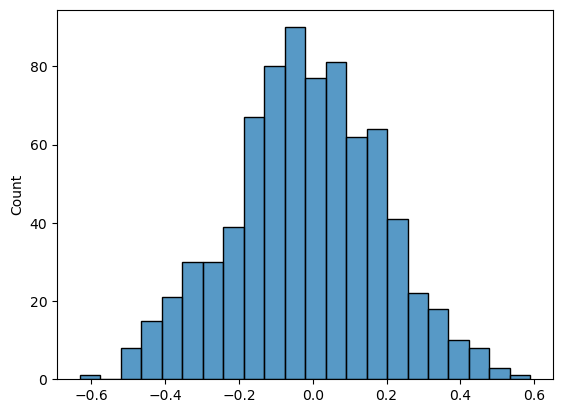

In [14]:
import seaborn as sns
sns.histplot(np.array(out)[0])

# Users

In [5]:
df = pd.read_xml('data/users.xml')
df

XMLSyntaxError: internal error: Huge input lookup, line 1295621, column 272 (<string>, line 1295621)

In [26]:
df.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus,Text,text
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open,mongodb. For Mongodb is it better to reference...,mongodb. For Mongodb is it better to reference...
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open,dom. xsd. jaxp. How to insert schemalocation i...,dom. xsd. jaxp. How to insert schemalocation i...
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open,sql-server. database-design. enums. Too many l...,sql-server. database-design. enums. Too many l...
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized,php. vb.net. What is this PHP code in VB.net. ...,php. vb.net. What is this PHP code in VB.net. ...
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open,mongodb. spring-data. Spring-Data mongodb quer...,mongodb. spring-data. Spring-Data mongodb quer...
